In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import pandas as pn
from datetime import datetime
import gsw
from holteandtalley import HolteAndTalley
import os
from xmovie import Movie

In [2]:
data = pn.DataFrame(data=np.empty([9,9]),columns = ['depth','temp','salt','lat','lon','year','month','day','profile#'])

In [3]:
#Opening the CTD data 1980-2021 WOD
k=1
for i in os.listdir("/Users/nyelab/Downloads/ocldb1619571763.24492.CTD/"):
    if i.startswith("wo"):
        string = '/Users/nyelab/Downloads/ocldb1619571763.24492.CTD/'+i
        array = xr.open_dataset(string)
        data2 = pn.DataFrame(data = array.Temperature, columns = ['temp'])
        try:
            data2['salt'] = array.Salinity
            depth = array.z.values
            Lon = array.lon.values
            Lat = array.lat.values
            year = pn.to_datetime(array.time.values).year
            month = pn.to_datetime(array.time.values).month
            day = pn.to_datetime(array.time.values).day
            data2['depth'] = depth
            data2['year']=year
            data2['month']=month
            data2['day']=day
            data2['lat']=Lat
            data2['lon']=Lon
            data2['profile#']=k
            k=k+1
            data = data.append(data2)
            array.close()
        except:
            an_array = np.empty((len(data2)))
            an_array[:] = np.NaN
            data2['salt'] = an_array
            depth = array.z.values
            Lon = array.lon.values
            Lat = array.lat.values
            year = pn.to_datetime(array.time.values).year
            month = pn.to_datetime(array.time.values).month
            day = pn.to_datetime(array.time.values).day
            data2['depth'] = depth
            data2['year']=year
            data2['month']=month
            data2['day']=day
            data2['lat']=Lat
            data2['lon']=Lon
            data2['profile#']=k
            k=k+1
            data = data.append(data2)
            array.close()

In [4]:
an_array = np.empty((len(data2)))


an_array[:] = np.NaN

an_array


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])

In [5]:
data

depth           temp           salt        lat            lon  \
0  -1.491668e-154 -1.491668e-154  8.942588e-322   0.000000   0.000000e+00   
1    0.000000e+00   0.000000e+00   0.000000e+00   0.000000  6.941163e-310   
2    0.000000e+00   0.000000e+00   0.000000e+00   0.000000   0.000000e+00   
3    0.000000e+00   0.000000e+00   0.000000e+00   0.000000   0.000000e+00   
4    0.000000e+00   0.000000e+00   0.000000e+00   0.000000   0.000000e+00   
..            ...            ...            ...        ...            ...   
35   3.770288e+01   7.970000e+00   3.189100e+01  40.726002  -7.187800e+01   
36   3.869497e+01   7.940000e+00   3.188800e+01  40.726002  -7.187800e+01   
37   3.968705e+01   7.930000e+00   3.189000e+01  40.726002  -7.187800e+01   
38   4.067913e+01   7.930000e+00   3.189800e+01  40.726002  -7.187800e+01   
39   4.167120e+01   7.910000e+00   3.190800e+01  40.726002  -7.187800e+01   

             year  month   day  profile#  
0    0.000000e+00    0.0   0.0       0.0  
1   6.941163e-310    0.0   0.0       0.0  
2    0.000000e+00    0.0   0.0       0.0  
3    0.000000e+00    0.0   0.0       0.0  
4    0.000000e+00    0.0   0.0       0.0  
..            ...    ...   ...       ...  
35   1.998000e+03    7.0  30.0   14781.0  
36   1.998000e+03    7.0  30.0   14781.0  
37   1.998000e+03    7.0  30.0   14781.0  
38   1.998000e+03    7.0  30.0   14781.0  
39   1.998000e+03    7.0  30.0   14781.0  

[891269 rows x 9 columns]

In [6]:
data['profile#'].max()

14781.0

In [7]:
data['pressure'] = gsw.p_from_z(-1*data['depth'].values,data['lat'].values)

In [8]:
data['SA'] = gsw.SA_from_SP(data.salt.values,data.pressure.values, data.lon.values, data.lat.values)

In [9]:
data['CT'] = gsw.CT_from_t(data.SA.values, data.temp.values, data.pressure.values)

/Users/nyelab/miniconda3/lib/python3.8/site-packages/gsw/_wrapped_ufuncs.py:696: RuntimeWarning: invalid value encountered in ct_from_t
  return _gsw_ufuncs.ct_from_t(SA, t, p)


In [10]:
data['sigma'] = gsw.sigma0(data.SA.values, data.CT.values)

In [11]:
mixeddf = pn.DataFrame(columns = ['lat','lon','year','month','day','profile#','mldT','mldS','mldr'])
mixeddf

Empty DataFrame
Columns: [lat, lon, year, month, day, profile#, mldT, mldS, mldr]
Index: []

In [12]:
data['mldT']=np.nan
data['mldS']=np.nan
data['mldr']=np.nan
for i in range(14781):
    try:
        profile = data[data['profile#']==i]
        mlds = HolteAndTalley(profile.pressure.values,profile.temp.values,profile.salt.values,profile.sigma.values)
        data.mldT[data['profile#']==i] = mlds.tempMLD
        data.mldS[data['profile#']==i] = mlds.salinityMLD
        data.mldr[data['profile#']==i] = mlds.densityMLD
        mixeddf=mixeddf.append({'lat':profile['lat'][0],'lon':profile['lon'][0],
                        'year':profile['year'][0],'month':profile['month'][0],
                        'day':profile['day'][0],'profile#':profile['profile#'][0],
                        'mldT':mlds.tempMLD, 'mldS':mlds.salinityMLD, 'mldr':mlds.densityMLD},ignore_index=True)
    except:
        pass

/Users/nyelab/miniconda3/lib/python3.8/site-packages/holteandtalley/profile.py:42: RuntimeWarning: invalid value encountered in true_divide
  mltBestFit = np.max(np.argwhere((errors/errorsum)> 10**-10))
/Users/nyelab/miniconda3/lib/python3.8/site-packages/holteandtalley/profile.py:42: RuntimeWarning: invalid value encountered in true_divide
  mltBestFit = np.max(np.argwhere((errors/errorsum)> 10**-10))
/Users/nyelab/miniconda3/lib/python3.8/site-packages/holteandtalley/profile.py:42: RuntimeWarning: invalid value encountered in true_divide
  mltBestFit = np.max(np.argwhere((errors/errorsum)> 10**-10))
/Users/nyelab/miniconda3/lib/python3.8/site-packages/holteandtalley/profile.py:42: RuntimeWarning: invalid value encountered in true_divide
  mltBestFit = np.max(np.argwhere((errors/errorsum)> 10**-10))
/Users/nyelab/miniconda3/lib/python3.8/site-packages/holteandtalley/profile.py:42: RuntimeWarning: invalid value encountered in true_divide
  mltBestFit = np.max(np.argwhere((errors/errors

In [ ]:
#mixeddf['mldr'][mixeddf['mldr']<0]=np.nan

In [ ]:
#mixeddf[mixeddf['lat']>40.75]=np.nan

In [13]:
mixeddf

lat        lon    year  month   day  profile#       mldT  \
0      39.094002 -74.633003  1989.0    6.0  14.0       1.0  10.199985   
1      40.615002 -71.883331  2013.0    3.0  30.0       2.0  10.999983   
2      41.276669 -71.251663  2000.0    2.0  24.0       3.0  13.999980   
3      39.978333 -71.498337  2001.0    2.0  14.0       4.0  39.846102   
4      41.099998 -71.644997  2006.0    8.0  16.0       5.0  11.444423   
...          ...        ...     ...    ...   ...       ...        ...   
12292  41.014999 -71.896667  2007.0    9.0  28.0   14774.0   9.999986   
12293  39.044998 -72.855003  2016.0    4.0  19.0   14775.0  50.999936   
12294  38.330002 -74.235001  2008.0    9.0  14.0   14776.0  10.952360   
12295  41.211666 -72.868332  2000.0    9.0  25.0   14777.0  10.999985   
12296  39.078335 -74.481667  2014.0    4.0  15.0   14779.0  11.999983   

            mldS       mldr  
0      10.199985  10.000000  
1       9.999986   9.999986  
2      13.500000  11.999983  
3      39.000000  39.000000  
4      10.500000   9.999986  
...          ...        ...  
12292  10.999985   9.999986  
12293  12.000000  12.000000  
12294  10.000000  10.000000  
12295  -8.000000   9.999986  
12296  10.000000  13.999981  

[12297 rows x 9 columns]

In [15]:
#mixeddf.to_csv(r'mixed_layer.csv', index = False)

In [2]:
mixeddf = pn.read_csv('/Users/nyelab/Desktop/NYB Indicators/CalculateIndicators/MixedLayer/mixed_layer.csv')

In [3]:
mixeddf

lat        lon    year  month   day  profile#       mldT  \
0      39.094002 -74.633003  1989.0    6.0  14.0       1.0  10.199985   
1      40.615002 -71.883331  2013.0    3.0  30.0       2.0  10.999983   
2      41.276669 -71.251663  2000.0    2.0  24.0       3.0  13.999980   
3      39.978333 -71.498337  2001.0    2.0  14.0       4.0  39.846102   
4      41.099998 -71.644997  2006.0    8.0  16.0       5.0  11.444423   
...          ...        ...     ...    ...   ...       ...        ...   
12292  41.014999 -71.896667  2007.0    9.0  28.0   14774.0   9.999986   
12293  39.044998 -72.855003  2016.0    4.0  19.0   14775.0  50.999936   
12294  38.330002 -74.235001  2008.0    9.0  14.0   14776.0  10.952360   
12295  41.211666 -72.868332  2000.0    9.0  25.0   14777.0  10.999985   
12296  39.078335 -74.481667  2014.0    4.0  15.0   14779.0  11.999983   

            mldS       mldr  
0      10.199985  10.000000  
1       9.999986   9.999986  
2      13.500000  11.999983  
3      39.000000  39.000000  
4      10.500000   9.999986  
...          ...        ...  
12292  10.999985   9.999986  
12293  12.000000  12.000000  
12294  10.000000  10.000000  
12295  -8.000000   9.999986  
12296  10.000000  13.999981  

[12297 rows x 9 columns]

In [4]:
np.unique(mixeddf.year)

array([1981., 1982., 1983., 1984., 1987., 1988., 1989., 1990., 1991.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019.])

In [17]:
def mixed_MAM_JJA(year, dataframe):
    mlyear = dataframe[dataframe['year']==year]
    mlyearMAM_1 = mlyear[mlyear['month']>=3]
    mlyearMAM = mlyearMAM_1[mlyearMAM_1['month']<=5]
    mlyearJJA_1=mlyear[mlyear['month']>=6]
    mlyearJJA = mlyearJJA_1[mlyearJJA_1['month']<=8]
    return mlyearMAM, mlyearJJA

In [18]:
[mam1998, jja1998] = mixed_MAM_JJA(1998,mixeddf)

In [25]:
[mam1999, jja1999] = mixed_MAM_JJA(1999,mixeddf)

In [37]:
mam1999

lat        lon    year  month   day  profile#       mldT  mldS  \
56     38.938332 -73.139999  1999.0    3.0   3.0      75.0  17.999965  17.0   
725    38.948334 -72.898331  1999.0    3.0   3.0     856.0  30.399951  30.0   
1150   39.246666 -72.415001  1999.0    3.0   2.0    1371.0  39.749951  41.5   
2893   38.283333 -74.934998  1999.0    3.0  18.0    3507.0   9.999986  10.5   
3189   39.561668 -74.143333  1999.0    3.0  20.0    3866.0   9.999986  10.0   
...          ...        ...     ...    ...   ...       ...        ...   ...   
10952  40.639999 -71.481667  1999.0    3.0  30.0   13129.0  15.999977  45.5   
11468  39.029999 -72.809998  1999.0    3.0   3.0   13757.0  24.999947  24.0   
11608  39.276669 -72.736664  1999.0    3.0   2.0   13946.0  32.999955  32.5   
12079  40.783333 -71.324997  1999.0    3.0  30.0   14518.0  10.999985  12.0   
12100  41.276669 -71.528336  1999.0    3.0  25.0   14543.0  10.999985  11.5   

            mldr  
56     17.000000  
725    30.000000  
1150   39.749951  
2893    9.999986  
3189    9.999986  
...          ...  
10952   2.999996  
11468  24.000000  
11608  31.437456  
12079  12.000000  
12100  11.500000  

[84 rows x 9 columns]

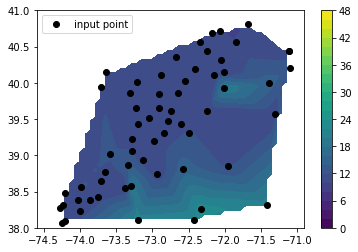

In [23]:
cp_djf= jja1998['mldT']
cplon_djf = jja1998['lon']
cplat_djf = jja1998['lat']

from scipy.interpolate import LinearNDInterpolator
#cp, cplat, cplon
x = cplon_djf

y = cplat_djf

z = cp_djf

X = np.linspace(-74.5, -71)

Y = np.linspace(38, 41)

X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

interp = LinearNDInterpolator(list(zip(x, y)), z)

Z = interp(X, Y)

#plt.pcolormesh(X, Y, Z,vmax = 20,vmin = 0 )#shading='auto'
plt.contourf(X, Y, Z,levels = np.arange(0,50,2),vmin=0)#shading='auto'
plt.plot(x, y, "ok", label="input point")

plt.legend()

plt.colorbar()

plt.axis("equal")

plt.show()

<ipython-input-31-388bbc6bb758>:32: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


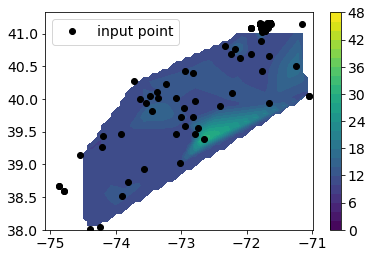

In [31]:
cp_djf= jja1999['mldT']
cplon_djf = jja1999['lon']
cplat_djf = jja1999['lat']

from scipy.interpolate import LinearNDInterpolator
#cp, cplat, cplon
x = cplon_djf

y = cplat_djf

z = cp_djf

Xa = np.linspace(-74.5, -71)

Ya = np.linspace(38, 41)

X, Y = np.meshgrid(Xa, Ya)  # 2D grid for interpolation

interp = LinearNDInterpolator(list(zip(x, y)), z)

Z = interp(X, Y)
#plt.pcolormesh(X, Y, Z,vmax = 20,vmin = 0 )#shading='auto'
plt.contourf(X, Y, Z,levels = np.arange(0,50,2),vmin=0)#shading='auto'
plt.plot(x, y, "ok", label="input point")

plt.legend()

plt.colorbar()

plt.axis("equal")

plt.show()

In [53]:
[mamyr, jjayr] = mixed_MAM_JJA(1981,mixeddf)
cp_djf= jjayr['mldT']
cplon_djf = jjayr['lon']
cplat_djf = jjayr['lat']
x = cplon_djf
y = cplat_djf
z = cp_djf
Xa = np.linspace(-74.5, -71)
Ya = np.linspace(38, 41)
X, Y = np.meshgrid(Xa, Ya)  # 2D grid for interpolation
interp = LinearNDInterpolator(list(zip(x, y)), z)
Z3 = interp(X, Y)

In [63]:
len(np.unique(mixeddf.year))

37

In [64]:
Znew = np.empty([50,50,37])

In [65]:
np.shape(Znew)

(50, 50, 37)

In [84]:
mldmam = np.empty([50,50,37])
k=0
for i in np.unique(mixeddf.year):
    try:
        [mamyr, jjayr] = mixed_MAM_JJA(i,mixeddf)
        cp_djf2= mamyr['mldT']
        cplon_djf2 = mamyr['lon']
        cplat_djf2 = mamyr['lat']
        x2 = cplon_djf2
        y2 = cplat_djf2
        z2 = cp_djf2
        Xa = np.linspace(-74.5, -71)
        Ya = np.linspace(38, 41)
        X, Y = np.meshgrid(Xa, Ya)  # 2D grid for interpolation
        interp2 = LinearNDInterpolator(list(zip(x2, y2)), z2)
        Z2 = interp2(X, Y)
        mldmam[:,:,k]=Z2
        k=k+1
    except:
        pass

In [85]:
mldjja = np.empty([50,50,37])
k=0
for i in np.unique(mixeddf.year):
    try:
        [mamyr, jjayr] = mixed_MAM_JJA(i,mixeddf)
        cp_djf= jjayr['mldT']
        cplon_djf = jjayr['lon']
        cplat_djf = jjayr['lat']
        x = cplon_djf
        y = cplat_djf
        z = cp_djf
        Xa = np.linspace(-74.5, -71)
        Ya = np.linspace(38, 41)
        X, Y = np.meshgrid(Xa, Ya)  # 2D grid for interpolation
        interp = LinearNDInterpolator(list(zip(x, y)), z)
        Z = interp(X, Y)
        mldjja[:,:,k]=Z
        k=k+1
    except:
        pass

In [86]:
mldjja

array([[[        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [        nan, 10.30215226,         nan, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [        nan,         nan,         nan, ...,  

In [87]:
test = xr.DataArray(data = mldjja,
                   dims = ['lon','lat','time'],
                   coords = {'lon': Xa,
                            'lat':Ya,
                            'time':np.unique(mixeddf.year)})

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
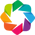

In [95]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh', 'matplotlib')

In [99]:
ds = hv.Dataset((np.unique(mixeddf.year),Xa, Ya, mldjja),
                ['time','lon','lat'], 'MLD')
ds

:Dataset   [time,lon,lat]   (MLD)

In [103]:
ds2 = hv.Dataset((np.unique(mixeddf.year),Xa, Ya, mldmam),
                ['time','lon','lat'], 'MLD')
ds2

:Dataset   [time,lon,lat]   (MLD)

In [100]:
type(ds.data), list(ds.data.keys())


(dict, ['time', 'lon', 'lat', 'MLD'])

In [101]:
opts.defaults(
    opts.GridSpace(shared_xaxis=True, shared_yaxis=True),
    opts.Image(cmap='viridis', width=400, height=400),
    opts.Labels(text_color='white', text_font_size='8pt', text_align='left', text_baseline='bottom'),
    opts.Path(color='white'),
    opts.Spread(width=600),
    opts.Overlay(show_legend=False))

In [111]:
img = ds.to(hv.Image, ['lon', 'lat']).opts(colorbar=True, xaxis=None, yaxis=None)

hv.Layout([img.relabel('JJA').opts(cmap='Viridis')])

:Layout
   .HoloMap.JJA :HoloMap   [time]
      :Image   [lon,lat]   (MLD)

In [116]:
img2 = ds2.to(hv.Image, ['lon', 'lat']).opts(colorbar=True, xaxis=None, yaxis=None)

hv.Layout([img2.relabel('MAM').opts(cmap='Viridis')])

/Users/nyelab/miniconda3/lib/python3.8/site-packages/holoviews/core/data/grid.py:811: RuntimeWarning: All-NaN slice encountered
  dmin, dmax = (np.nanmin(array), np.nanmax(array))
/Users/nyelab/miniconda3/lib/python3.8/site-packages/holoviews/core/data/grid.py:811: RuntimeWarning: All-NaN slice encountered
  dmin, dmax = (np.nanmin(array), np.nanmax(array))
/Users/nyelab/miniconda3/lib/python3.8/site-packages/holoviews/core/data/grid.py:811: RuntimeWarning: All-NaN slice encountered
  dmin, dmax = (np.nanmin(array), np.nanmax(array))


/Users/nyelab/miniconda3/lib/python3.8/site-packages/holoviews/core/data/grid.py:811: RuntimeWarning: All-NaN slice encountered
  dmin, dmax = (np.nanmin(array), np.nanmax(array))
/Users/nyelab/miniconda3/lib/python3.8/site-packages/holoviews/core/data/grid.py:811: RuntimeWarning: All-NaN slice encountered
  dmin, dmax = (np.nanmin(array), np.nanmax(array))
/Users/nyelab/miniconda3/lib/python3.8/site-packages/holoviews/core/data/grid.py:811: RuntimeWarning: All-NaN slice encountered
  dmin, dmax = (np.nanmin(array), np.nanmax(array))
/Users/nyelab/miniconda3/lib/python3.8/site-packages/holoviews/core/data/grid.py:811: RuntimeWarning: All-NaN slice encountered
  dmin, dmax = (np.nanmin(array), np.nanmax(array))
/Users/nyelab/miniconda3/lib/python3.8/site-packages/holoviews/core/data/grid.py:811: RuntimeWarning: All-NaN slice encountered
  dmin, dmax = (np.nanmin(array), np.nanmax(array))
/Users/nyelab/miniconda3/lib/python3.8/site-packages/holoviews/core/data/grid.py:811: RuntimeWarning

:Layout
   .HoloMap.MAM :HoloMap   [time]
      :Image   [lon,lat]   (MLD)

In [89]:
mov = Movie(test)

/Users/nyelab/miniconda3/lib/python3.8/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/nyelab/miniconda3/lib/python3.8/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


In [93]:
#mov.preview(10)
mov.save('testmovie.gif',verbose=True)

ffmpeg version 4.0 Copyright (c) 2000-2018 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/Users/nyelab/miniconda3 --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-shared --enable-static --enable-zlib --enable-pic --enable-gpl --enable-version3 --disable-nonfree --enable-hardcoded-tables --enable-avresample --enable-libfreetype --disable-openssl --disable-gnutls --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --disable-libx264
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Unrecognized option 'preset'.
Error splitting the argument list: Option not found


RuntimeError: Something has gone wrong. Use `verbose=True` to check if ffmpeg displays a problem

In [ ]:
data_uor = pn.DataFrame(data=np.empty([9,9]),columns = ['depth','temp','salt','lat','lon','year','month','day','profile#'])

In [ ]:
#Opening the UOR data 1980-2021 WOD
k=1
for i in os.listdir("/Users/nyelab/Downloads/ocldb1619571763.24492.UOR/"):
    if i.startswith("wo"):
        string = '/Users/nyelab/Downloads/ocldb1619571763.24492.UOR/'+i
        array = xr.open_dataset(string)
        data2 = pn.DataFrame(data = array.Temperature, columns = ['temp'])
        try:
            data2['salt'] = array.Salinity
            depth = array.z.values
            Lon = array.lon.values
            Lat = array.lat.values
            year = pn.to_datetime(array.time.values).year
            month = pn.to_datetime(array.time.values).month
            day = pn.to_datetime(array.time.values).day
            data2['depth'] = depth
            data2['year']=year
            data2['month']=month
            data2['day']=day
            data2['lat']=Lat
            data2['lon']=Lon
            data2['profile#']=k
            k=k+1
            data_uor = data_uor.append(data2)
            array.close()
        except:
            an_array = np.empty((len(data2)))
            an_array[:] = np.NaN
            data2['salt'] = an_array
            depth = array.z.values
            Lon = array.lon.values
            Lat = array.lat.values
            year = pn.to_datetime(array.time.values).year
            month = pn.to_datetime(array.time.values).month
            day = pn.to_datetime(array.time.values).day
            data2['depth'] = depth
            data2['year']=year
            data2['month']=month
            data2['day']=day
            data2['lat']=Lat
            data2['lon']=Lon
            data2['profile#']=k
            k=k+1
            data_uor = data_uor.append(data2)
            array.close()

In [ ]:
data_uor['profile#'].max()

In [ ]:
data_uor['pressure'] = gsw.p_from_z(-1*data_uor['depth'].values,data_uor['lat'].values)

In [ ]:
data_uor['SA'] = gsw.SA_from_SP(data_uor.salt.values,data_uor.pressure.values, data_uor.lon.values, data_uor.lat.values)

In [ ]:
data_uor['CT'] = gsw.CT_from_t(data_uor.SA.values, data_uor.temp.values, data_uor.pressure.values)

In [ ]:
data_uor['sigma'] = gsw.sigma0(data_uor.SA.values, data_uor.CT.values)

In [ ]:
mixeddf_uor = pn.DataFrame(columns = ['lat','lon','year','month','day','profile#','mldT','mldS','mldr'])
mixeddf_uor

In [ ]:
data_uor['mldT']=np.nan
data_uor['mldS']=np.nan
data_uor['mldr']=np.nan
for i in range(15014):
    try:
        profile = data_uor[data_uor['profile#']==i]
        mlds = HolteAndTalley(profile.pressure.values,profile.temp.values,profile.salt.values,profile.sigma.values)
        data_uor.mldT[data['profile#']==i] = mlds.tempMLD
        data_uor.mldS[data['profile#']==i] = mlds.salinityMLD
        data_uor.mldr[data['profile#']==i] = mlds.densityMLD
        mixeddf_uor=mixeddf_uor.append({'lat':profile['lat'][0],'lon':profile['lon'][0],
                        'year':profile['year'][0],'month':profile['month'][0],
                        'day':profile['day'][0],'profile#':profile['profile#'][0],
                        'mldT':mlds.tempMLD, 'mldS':mlds.salinityMLD, 'mldr':mlds.densityMLD},ignore_index=True)
    except:
        pass

In [ ]:
35014

In [160]:
np.shape(monthly)

(37, 12)

In [5]:
monthly = np.empty([len(np.unique(mixeddf.year)),12])

In [6]:
k=0
for i in (np.unique(mixeddf.year)):
    mixedyear = mixeddf[mixeddf.year == i]
    for j in range(12):
        if any(mixedyear.month == float(j+1)):
            mixedmonth = mixedyear[(mixedyear.month == float(j+1))]
            if len(mixedmonth)<3:
                monthly[k,j] = np.nan
            else:
                monthly[k,j] = np.nanmean(mixedmonth.mldT)
        else:
            monthly[k,j] = np.nan
    k = k+1

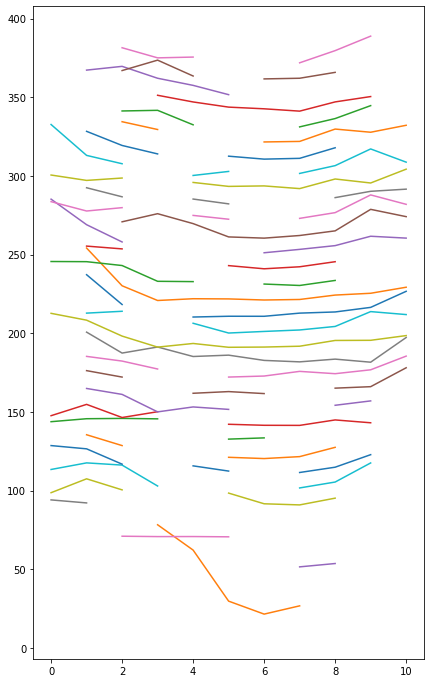

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize = [7,12])
for i in range(37):
    ax.plot(monthly[i,:]+(10*i))
#ax.set_ylim([15,20])
#ax.ymax(20)

In [9]:
plt.plot([1,2,3,4],[5,6,7,8])


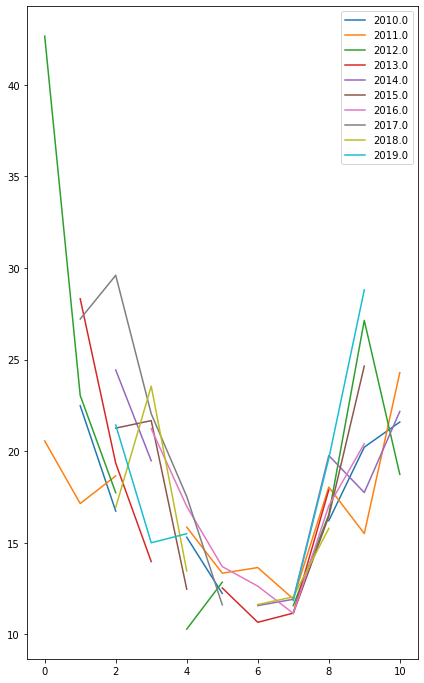

In [16]:
fig, ax = plt.subplots(figsize = [7,12])
for i in range(27,37):
    ax.plot(monthly[i,:],label = str(np.unique(mixeddf.year)[i]))
ax.legend()
#ax.set_ylim([15,20])

#ax.ymax(20)

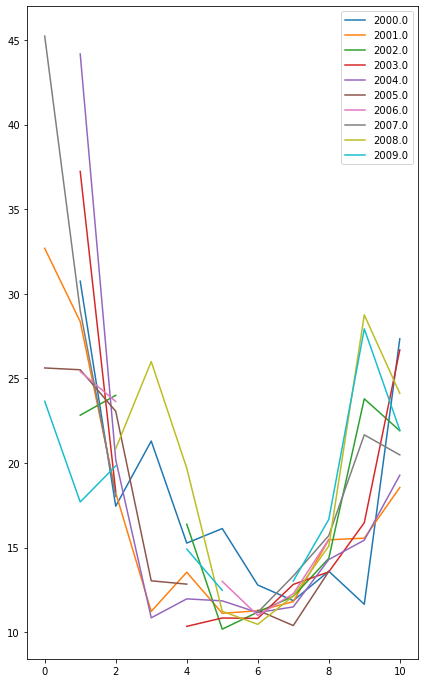

In [17]:
fig, ax = plt.subplots(figsize = [7,12])
for i in range(17,27):
    ax.plot(monthly[i,:],label = str(np.unique(mixeddf.year)[i]))
ax.legend()
#ax.set_ylim([15,20])

#ax.ymax(20)

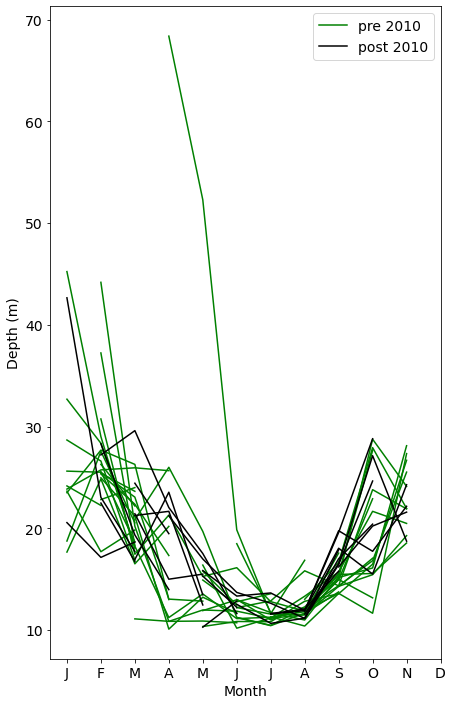

In [54]:
fig, ax = plt.subplots(figsize = [7,12])

h1 = ax.plot(np.arange(0,12),monthly[0,:],color = 'g', label = 'pre 2010')

for i in range(0,27):
    ax.plot(np.arange(0,12),monthly[i,:],color = 'g',label = '_hidden')

h3 = ax.plot(np.arange(0,12),monthly[27,:],color = 'k', label = 'post 2010')
for i in range(28,37):
    ax.plot(np.arange(0,12),monthly[i,:], color = 'k', label = '_hidden')

ax.legend(fontsize = 14)

ax.set_ylabel('Depth (m)', fontsize = 14)
ax.set_xlabel('Month', fontsize = 14)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize = 14)
ax.tick_params(axis='y', labelsize=14)
#ax.set_ylim([15,20])

#ax.ymax(20)

Text(0.5, 1.0, 'Seasonal MLD Development')

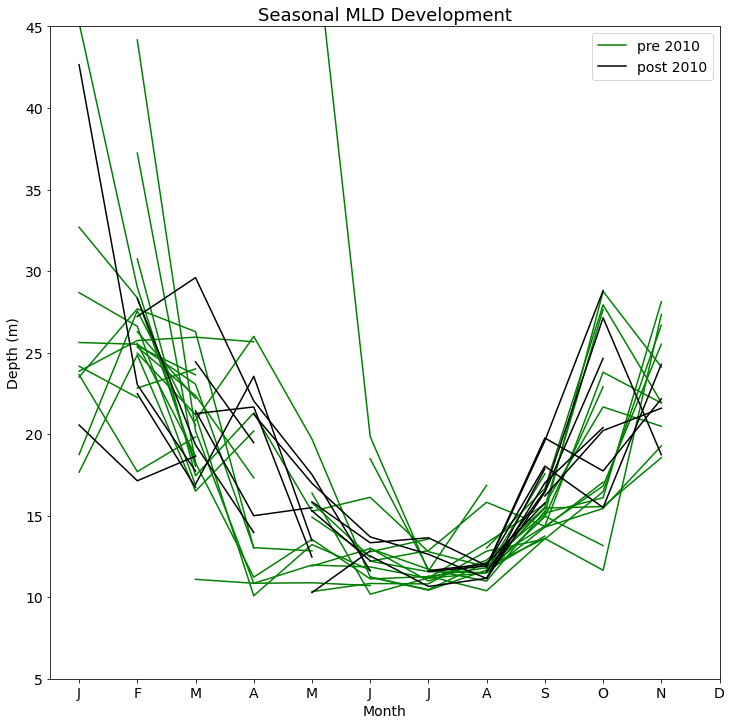

In [60]:
fig, ax = plt.subplots(figsize = [12,12])

h1 = ax.plot(np.arange(0,12),monthly[0,:],color = 'g', label = 'pre 2010')

for i in range(0,27):
    ax.plot(np.arange(0,12),monthly[i,:],color = 'g',label = '_hidden')

h3 = ax.plot(np.arange(0,12),monthly[27,:],color = 'k', label = 'post 2010')
for i in range(28,37):
    ax.plot(np.arange(0,12),monthly[i,:], color = 'k', label = '_hidden')

ax.legend(fontsize = 14)

ax.set_ylabel('Depth (m)', fontsize = 14)
ax.set_xlabel('Month', fontsize = 14)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize = 14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim([5,45])
ax.set_title('Seasonal MLD Development', fontsize =18)

#ax.ymax(20)

In [226]:
mixedyear = mixeddf[mixeddf.year == 2013.0]
test = np.empty(12)
test

array([-1.49166815e-154, -1.49166815e-154,  3.95252517e-323,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000])

In [236]:
for j in range(12):
    if any(mixedyear.month == float(j+1)):
        mixedmonth = mixedyear[(mixedyear.month == float(j+1))]
        if len(mixedmonth)<3:
            test[j] = np.nan
        else:
            test[j] = np.nanmean(mixedmonth.mldT)
    else:
            test[j] = np.nan

In [237]:
test

array([        nan, 28.31994686, 19.34449708, 13.97497989,         nan,
       12.5356297 , 10.66148266, 11.16267013, 17.88122074,         nan,
       22.54620319,         nan])

In [235]:
j=1
mixedmonth = mixedyear[(mixedyear.month == float(j+1))]
mixedmonth

lat        lon    year  month   day  profile#        mldT  \
1830   41.008335 -71.281670  2013.0    2.0  25.0    2215.0   21.999969   
2024   41.305000 -71.275002  2013.0    2.0  25.0    2444.0   19.999971   
3209   39.893333 -72.853333  2013.0    2.0  13.0    3889.0   18.999972   
3292   40.331665 -73.508331  2013.0    2.0  14.0    3983.0   16.999976   
3299   39.141666 -74.328331  2013.0    2.0  14.0    3992.0   11.999983   
3571   39.233334 -73.870003  2013.0    2.0  14.0    4322.0   22.999969   
3589   40.331665 -73.500000  2013.0    2.0  14.0    4342.0   15.999976   
3659   39.805000 -73.036667  2013.0    2.0  13.0    4425.0   17.999973   
4042   39.381668 -73.536667  2013.0    2.0  13.0    4895.0   36.999949   
4045   39.708332 -74.010002  2013.0    2.0  14.0    4900.0   11.999983   
4333   40.000000 -73.511665  2013.0    2.0  14.0    5239.0   22.999968   
4347   39.095001 -73.650002  2013.0    2.0  14.0    5258.0   29.999958   
4795   39.581665 -73.161667  2013.0    2.0  13.0    5776.0   18.999973   
4816   40.411667 -72.801666  2013.0    2.0  14.0    5800.0   10.999983   
5170   40.411667 -72.805000  2013.0    2.0  14.0    6221.0   29.999958   
5174   39.576668 -73.163330  2013.0    2.0  13.0    6227.0   17.999974   
5583   38.806667 -73.666664  2013.0    2.0  12.0    6705.0   19.999973   
5588   40.758335 -72.165001  2013.0    2.0  14.0    6710.0   14.399982   
5612   39.250000 -73.050003  2013.0    2.0  13.0    6735.0    9.999986   
5958   39.178333 -73.246666  2013.0    2.0  13.0    7134.0   27.999960   
5968   40.651665 -72.198334  2013.0    2.0  14.0    7144.0   22.999968   
5983   38.560001 -73.736664  2013.0    2.0  12.0    7163.0   12.999982   
6336   38.811668 -74.543335  2013.0    2.0  12.0    7584.0   11.999983   
6342   38.856667 -73.143333  2013.0    2.0  12.0    7592.0    9.999986   
6728   38.861668 -73.135002  2013.0    2.0  12.0    8063.0    9.999986   
6744   38.369999 -74.418335  2013.0    2.0  12.0    8085.0   24.999962   
7076   39.011665 -72.584999  2013.0    2.0  13.0    8487.0  181.142678   
7080   38.806667 -74.550003  2013.0    2.0  12.0    8491.0    9.999987   
7093   39.976665 -71.236664  2013.0    2.0  15.0    8506.0   82.999904   
7471   40.113335 -71.968330  2013.0    2.0  15.0    8953.0   32.499950   
7475   38.578335 -73.745003  2013.0    2.0  12.0    8958.0   16.999978   
7490   39.053333 -72.741669  2013.0    2.0  13.0    8974.0   82.999892   
7815   39.900002 -72.518333  2013.0    2.0  13.0    9358.0   40.999946   
7824   38.361668 -74.671669  2013.0    2.0  12.0    9370.0   20.249967   
7846   40.139999 -71.291664  2013.0    2.0  15.0    9396.0   17.636334   
7891   39.218334 -74.196663  2013.0    2.0  14.0    9447.0    9.999986   
8167   39.343334 -74.029999  2013.0    2.0  14.0    9797.0    9.999986   
8228   38.198334 -74.583336  2013.0    2.0  12.0    9871.0   10.999983   
8232   39.811668 -72.324997  2013.0    2.0  13.0    9876.0   43.749943   
8568   39.623333 -72.458336  2013.0    2.0  13.0   10277.0   78.999905   
8999   39.595001 -72.368332  2013.0    2.0  13.0   10781.0   47.999935   
9440   40.641666 -71.431664  2013.0    2.0  25.0   11316.0   44.999940   
9450   41.513332 -71.355003  2013.0    2.0  24.0   11329.0   10.999983   
9652   41.303333 -71.268333  2013.0    2.0  25.0   11573.0   24.999965   
9655   40.445000 -71.366669  2013.0    2.0  26.0   11576.0   52.999934   
10241  41.294998 -71.103333  2013.0    2.0  24.0   12262.0   12.999981   
10258  40.863335 -71.561668  2013.0    2.0  25.0   12282.0   26.999965   
10449  41.014999 -71.293335  2013.0    2.0  25.0   12523.0   23.999967   
11012  40.508335 -71.208336  2013.0    2.0  26.0   13206.0    9.999986   

             mldS        mldr  
1830   -21.000000  -21.000000  
2024    -9.000000   -9.000000  
3209   -69.000000  -69.000000  
3292    -1.500000   16.999976  
3299  -159.500000 -159.500000  
3571    24.000000   23.999968  
3589    14.999977   14.999977  
3659   -43.000000  -43.000000  
4042    35.999954   35.9

In [155]:
np.nanmean(mixeddf.mldT[(mixedyear.month == float(j+1)).index])

12.059235954159961

In [171]:
mixedyear = mixeddf[mixeddf.year == 2000.0]

In [177]:
mixedyear = mixeddf[mixeddf.year == i]

In [181]:
mixedyear = mixeddf[mixeddf.year == 1980.0]

In [184]:
(np.unique(mixeddf.year))

array([1981., 1982., 1983., 1984., 1987., 1988., 1989., 1990., 1991.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019.])

In [189]:
mixedyear = mixeddf[mixeddf.year == 1981.0]

In [193]:
for j in range(12):
        if any(mixedyear.month == float(j+1)):
            mixedmonth = mixeddf.mldT[(mixedyear.month == float(j+1)).index]
            if len(mixedmonth<3):
                monthly[k,j] = np.nan
            else:
                monthly[k,j] = np.nanmean(mixedmonth)
        else:
            monthly[k,j] = np.nan

In [195]:
j=5

In [196]:
mixedmonth = mixeddf.mldT[(mixedyear.month == float(j+1)).index]

In [197]:
mixedmonth

4728    13.364075
6278    11.262450
8252    11.852861
8547    11.757558
Name: mldT, dtype: float64

In [201]:
if len(mixedmonth)<3:
                A = np.nan
else:
                A = np.nanmean(mixedmonth)

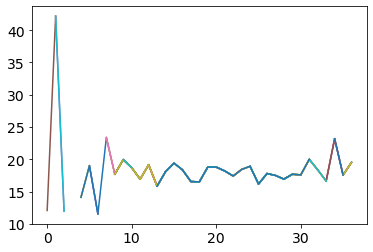

In [206]:
plt.plot(monthly)